In [0]:
# For google colab
# ! pip install deeppavlov
# ! pip install pybind11

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from typing import *
import copy
from deeppavlov.dataset_readers.ontonotes_reader import OntonotesReader

In [0]:
TRAIN_ELMO = True
TRAIN_ALL_ELMO_PARAMS = 1

In [0]:
def read_data():
    reader = OntonotesReader()
    dataset = reader.read(data_path='data/')
    # print(dataset.keys())
    print('Num of train sentences: {}'.format(len(dataset['train'])))
    print('Num of valid sentences: {}'.format(len(dataset['valid'])))
    print('Num of test sentences: {}'.format(len(dataset['test'])))
    print(dataset['train'][50:60])
    return dataset

def filter_data_by_ne_type(data:list, ne_types:list, tags2binary=False, preserveBIO=False, keepIfAny=True):
    if ne_types == None or len(ne_types) == 0:
        return data
    data_filtered = []
    for tokens,tags in data:
        contains_all = True
        contains_any = False
        tags_norm = [getNeTagMainPart(t) for t in tags]
        for ne_type in ne_types:
            if not ne_type in tags_norm:
                contains_all = False
            if ne_type in tags_norm:
                contains_any = True
        if contains_all or (keepIfAny and contains_any):
            if tags2binary:
                if preserveBIO:
                    tags = [tags[i][:2]+'T' if t in ne_types else 'O' for i,t in enumerate(tags_norm)]
                else:
                    tags = ['T' if t in ne_types else 'O' for t in tags_norm]
            data_filtered.append((tokens,tags))
    return data_filtered

def filter_dataset_by_ne_types(dataset: list, ne_types, preserveBIO=False, keepIfAny=True):
    dataset = copy.deepcopy(dataset)
    if not isinstance(ne_types, list):
        ne_types = [ne_types]
    for dataset_type in ['train', 'valid', 'test']:
        dataset[dataset_type] = filter_data_by_ne_type(dataset[dataset_type], ne_types, preserveBIO=preserveBIO, tags2binary=True)
        print('Num of {} sentences: {}'.format(dataset_type, len(dataset[dataset_type])))
    return dataset

def get_data_sample(data, n_samples: int):
    indices = np.random.choice(len(data), size=n_samples, replace=False)
    return split_tokens_tags([data[i] for i in indices])

def get_tokens_len(tokens):
    if isinstance(tokens[0], str):
        tokens = [tokens]
    return [len(seq) for seq in tokens]

def to_lower_case(tokens:list):
    tokens_lower = []
    for seq in tokens:
        tokens_lower.append([])
        for token in seq:
            tokens_lower[-1].append(token.lower())
    return tokens_lower

def add_padding(tokens:list):
    if isinstance(tokens[0], str):
        return tokens, len(tokens)
    elif isinstance(tokens[0], list):
        tokens = copy.deepcopy(tokens)
        max_len = 0
        for seq in tokens:
            if len(seq) > max_len:
                max_len = len(seq)
        for seq in tokens:
            i = len(seq)
            while i < max_len:
                seq.append('')
                i += 1
        return tokens
    else:
        raise Exception('tokens should be either list of strings or list of lists of strings')
  
def getNeTagMainPart(tag:str):
    return tag[2:] if tag != 'O' else tag

def tags2binaryFlat(tags):
    return np.array([1 if t == 'T' or (len(t) > 2 and t[2:] == 'T') else 0 for seq in tags for t in seq])

def tags2binaryPadded(tags:list):
    if isinstance(tags[0], str):
        tags = [tags]
    n_sentences = len(tags)
    tokens_length = get_tokens_len(tags)
    max_len = np.max(tokens_length)
    tokens_length = np.tile(np.expand_dims(tokens_length, -1), (1,max_len))
    y = np.zeros((n_sentences, max_len))
    range_ar = np.tile(np.arange(1, max_len+1, 1), (n_sentences, 1))
    for i, sen in enumerate(tags):
        for j, tag in enumerate(sen):
            if tags[i][j] != 'O':
                y[i][j] = 1
#     y[range_ar > tokens_length] = -1
    return y

def get_matrices(tokens, tags, embedder):
    return (embeddings2feat_mat(embedder.embed(tokens), get_tokens_len(tokens)),
           tags2binaryFlat(tags))
  
def split_tokens_tags(dataset: list):
    tokens = []
    tags = []
    for sample in dataset:
        tokens.append(sample[0])
        tags.append(sample[1])
    return tokens, tags

In [34]:
dataset_orig = read_data()
# ne_type = 'PERSON'
ne_types = ['GPE','DATE','ORG','EVENT','LOC','FAC','CARDINAL','QUANTITY','NORP','ORDINAL','WORK_OF_ART']
# ne_types = ['GPE','DATE','ORG','EVENT','LOC','FAC','CARDINAL','QUANTITY','NORP','ORDINAL','WORK_OF_ART', 'LANGUAGE', 'TIME', 'PRODUCT', 'MONEY', 'LAW', 'PERCENT']
# dataset = {'train':[], 'valid':[], 'test':[]}
# for ne_type in ne_types:
#     print(ne_type)
#     dataset_cur = filter_dataset_by_ne_types(dataset_orig, ne_type)
#     for k in dataset.keys():
#         dataset[k].extend(dataset_cur[k])
dataset = filter_dataset_by_ne_types(dataset_orig, ne_types, keepIfAny=True)
print('Number of sentences in filtered dataset: train: {}, valid: {}, test: {}'.format(len(dataset['train']), len(dataset['valid']), len(dataset['test'])))

Num of train sentences: 75187
Num of valid sentences: 9603
Num of test sentences: 9479
[(['Actions', 'had', 'to', 'be', 'taken', 'to', 'break', 'through', 'the', 'blockade', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'a', 'night', 'in', 'late', 'July', '1940', ',', 'the', 'atmosphere', 'in', 'Zhuanbi', 'Village', 'in', 'Shaanxi', 'was', 'unusual', '.'], ['O', 'B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'B-GPE', 'I-GPE', 'O', 'B-GPE', 'O', 'O', 'O']), (['Villager', 'Xiao', 'Jianghe', 'has', 'a', 'vivid', 'memory', 'of', 'this', 'piece', 'of', 'history', '.'], ['O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'that', 'dark', 'night', ',', 'everyone', 'was', 'sleeping', 'when', 'human', 'voices', 'and', 'neighing', 'horses', 'were', 'heard', 'within', 'the', 'village', '.'], ['O', 'B-TIME', 'I-TIME', 'I-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [0]:
# dataset_zipped = [list(zip(tokens, tags)) for tokens,tags in dataset['train']]
# for sent in dataset_zipped:
#   for token, tag in sent:
#     print('{}\t{}'.format(token, tag))
#   print()

In [0]:
INITIALIZER = tf.contrib.layers.xavier_initializer

def bi_rnn(units: tf.Tensor,
           n_hidden: List,
           cell_type='gru',
           seq_lengths=None,
           trainable_initial_states=False,
           use_peepholes=False,
           name='Bi-'):
    """ Bi directional recurrent neural network. GRU or LSTM

        Args:
            units: a tensorflow tensor with dimensionality [None, n_tokens, n_features]
            n_hidden_list: list with number of hidden units at the ouput of each layer
            seq_lengths: length of sequences for different length sequences in batch
                can be None for maximum length as a length for every sample in the batch
            cell_type: 'lstm' or 'gru'
            trainable_initial_states: whether to create a special trainable variable
                to initialize the hidden states of the network or use just zeros
            use_peepholes: whether to use peephole connections (only 'lstm' case affected)
            name: what variable_scope to use for the network parameters
            add_l2_losses: whether to add l2 losses on network kernels to
                tf.GraphKeys.REGULARIZATION_LOSSES or not
        Returns:
            units: tensor at the output of the last recurrent layer
                with dimensionality [None, n_tokens, n_hidden_list[-1]]
            last_units: tensor of last hidden states for GRU and tuple
                of last hidden stated and last cell states for LSTM
                dimensionality of cell states and hidden states are
                similar and equal to [B x 2 * H], where B - batch
                size and H is number of hidden units
    """

    with tf.variable_scope(name + '_' + cell_type.upper()):
        if cell_type == 'gru':
            forward_cell = tf.nn.rnn_cell.GRUCell(n_hidden, kernel_initializer=INITIALIZER())
            backward_cell = tf.nn.rnn_cell.GRUCell(n_hidden, kernel_initializer=INITIALIZER())
            if trainable_initial_states:
                initial_state_fw = tf.tile(tf.get_variable('init_fw_h', [1, n_hidden]), (tf.shape(units)[0], 1))
                initial_state_bw = tf.tile(tf.get_variable('init_bw_h', [1, n_hidden]), (tf.shape(units)[0], 1))
            else:
                initial_state_fw = initial_state_bw = None
        elif cell_type == 'lstm':
            forward_cell = tf.nn.rnn_cell.LSTMCell(n_hidden, use_peepholes=use_peepholes, initializer=INITIALIZER())
            backward_cell = tf.nn.rnn_cell.LSTMCell(n_hidden, use_peepholes=use_peepholes, initializer=INITIALIZER())
            if trainable_initial_states:
                initial_state_fw = tf.nn.rnn_cell.LSTMStateTuple(
                    tf.tile(tf.get_variable('init_fw_c', [1, n_hidden]), (tf.shape(units)[0], 1)),
                    tf.tile(tf.get_variable('init_fw_h', [1, n_hidden]), (tf.shape(units)[0], 1)))
                initial_state_bw = tf.nn.rnn_cell.LSTMStateTuple(
                    tf.tile(tf.get_variable('init_bw_c', [1, n_hidden]), (tf.shape(units)[0], 1)),
                    tf.tile(tf.get_variable('init_bw_h', [1, n_hidden]), (tf.shape(units)[0], 1)))
            else:
                initial_state_fw = initial_state_bw = None
        else:
            raise RuntimeError('cell_type must be either "gru" or "lstm"s')
        (rnn_output_fw, rnn_output_bw), (fw, bw) = \
            tf.nn.bidirectional_dynamic_rnn(forward_cell,
                                            backward_cell,
                                            units,
                                            dtype=tf.float32,
                                            sequence_length=seq_lengths,
                                            initial_state_fw=initial_state_fw,
                                            initial_state_bw=initial_state_bw)
    kernels = [var for var in forward_cell.trainable_variables +
               backward_cell.trainable_variables if 'kernel' in var.name]
    for kernel in kernels:
        tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(kernel))
    return (rnn_output_fw, rnn_output_bw), (fw, bw)

def build_cudnn_rnn(units, mask, n_hidden_list:Tuple[int]=(128,), cell_type:str='lstm', intra_layer_dropout:bool=False, dropout_ph=None):
    sequence_lengths = tf.to_int32(tf.reduce_sum(mask, axis=1))
    for n, n_hidden in enumerate(n_hidden_list):
        with tf.variable_scope(cell_type.upper() + '_' + str(n)):
            if cell_type.lower() == 'lstm':
                units, _ = cudnn_bi_lstm(units, n_hidden, sequence_lengths)
            elif cell_type.lower() == 'gru':
                units, _ = cudnn_bi_gru(units, n_hidden, sequence_lengths)
            else:
                raise RuntimeError('Wrong cell type "{}"! Only "gru" and "lstm"!'.format(cell_type))
            units = tf.concat(units, -1)
            if intra_layer_dropout and n != len(n_hidden_list) - 1:
                units = variational_dropout(units, dropout_ph)
    return units

def build_rnn(units, n_hidden_list:Tuple[int]=(128,), cell_type:str='lstm', intra_layer_dropout:bool=False, dropout_ph=None):
    for n, n_hidden in enumerate(n_hidden_list):
        units, _ = bi_rnn(units, n_hidden, cell_type=cell_type, name='Layer_' + str(n))
        units = tf.concat(units, -1)
        if intra_layer_dropout and n != len(n_hidden_list) - 1:
            units = variational_dropout(units, dropout_ph)
    return units

def build_top(units, n_tags=1, top_dropout:bool=False, two_dense_on_top:bool=False, n_hidden=128):
    if top_dropout:
        units = variational_dropout(units, dropout_ph)
    if two_dense_on_top:
        units = tf.layers.dense(units, n_hidden, activation=tf.nn.relu,
                                kernel_initializer=INITIALIZER(),
                                kernel_regularizer=tf.nn.l2_loss)
    logits = tf.layers.dense(units, n_tags, activation=None,
                             kernel_initializer=INITIALIZER(),
                             kernel_regularizer=tf.nn.l2_loss)
    return logits

def build_train_predict(logits, n_tags, mask, y_ph, use_crf, learning_rate_ph, clip_grad_norm, l2_reg):
    res = {}
    if use_crf:
        sequence_lengths = tf.reduce_sum(mask, axis=1)
        log_likelihood, transition_params = tf.contrib.crf.crf_log_likelihood(logits, y_ph, sequence_lengths)
        loss_tensor = -log_likelihood
        res['transition_params'] = transition_params
    else:
        ground_truth_labels = tf.one_hot(y_ph, n_tags)
        loss_tensor = tf.nn.softmax_cross_entropy_with_logits(labels=ground_truth_labels, logits=logits)
        loss_tensor = loss_tensor * mask
        y_pred = tf.argmax(logits, axis=-1)
        res['y_pred'] = y_pred

    loss = tf.reduce_mean(loss_tensor)

    # L2 regularization
    if l2_reg > 0:
        loss += l2_reg * tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
    res['loss'] = loss
        
    # optimizer = partial(tf.train.MomentumOptimizer, momentum=0.9, use_nesterov=True)
    optimizer = tf.train.AdamOptimizer
    train_op = get_train_op(loss, learning_rate_ph, optimizer, clip_norm=clip_grad_norm)
    res['train_op'] = train_op
    return res

def predict_no_crf(y_pred, mask_ph, feed_dict):
    pred_idxs, mask = sess.run([y_pred, mask_ph], feed_dict)

    # Filter by sequece length
    sequence_lengths = np.sum(mask, axis=1).astype(np.int32)
    pred = []
    for utt, l in zip(pred_idxs, sequence_lengths):
        pred.append(utt[:l])
    return pred

def predict_crf(logits, transition_params, mask_ph, feed_dict):
    logits, trans_params, mask = sess.run([logits,
                                           transition_params,
                                           mask_ph],
                                           feed_dict=feed_dict)
    sequence_lengths = np.maximum(np.sum(mask, axis=1).astype(np.int32), 1)
    # iterate over the sentences because no batching in viterbi_decode
    pred = []
    for logit, sequence_length in zip(logits, sequence_lengths):
        logit = logit[:int(sequence_length)]  # keep only the valid steps
        viterbi_seq, viterbi_score = tf.contrib.crf.viterbi_decode(logit, trans_params)
        pred += [viterbi_seq]
    return pred

def get_train_op(loss,
                 learning_rate,
                 optimizer=None,
                 clip_norm=None,
                 learnable_scopes=None,
                 optimizer_scope_name=None,
                 trainable_vars:list=None):
    """ Get train operation for given loss

    Args:
        loss: loss, tf tensor or scalar
        learning_rate: scalar or placeholder
        clip_norm: clip gradients norm by clip_norm
        learnable_scopes: which scopes are trainable (None for all)
        optimizer: instance of tf.train.Optimizer, default Adam

    Returns:
        train_op
    """
    if optimizer_scope_name is None:
        opt_scope = tf.variable_scope('Optimizer')
    else:
        opt_scope = tf.variable_scope(optimizer_scope_name)
    with opt_scope:
        if learnable_scopes is None:
            variables_to_train = tf.global_variables()
        else:
            variables_to_train = []
            for scope_name in learnable_scopes:
                for var in tf.global_variables():
                    if scope_name in var.name:
                        variables_to_train.append(var)
        if trainable_vars:
            variables_to_train = trainable_vars
            
        if optimizer is None:
            optimizer = tf.train.AdamOptimizer

        # For batch norm it is necessary to update running averages
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(extra_update_ops):
            opt = optimizer(learning_rate)
            grads_and_vars = opt.compute_gradients(loss, var_list=variables_to_train)
            if clip_norm is not None:
                grads_and_vars = [(tf.clip_by_norm(grad, clip_norm), var)
                                  for grad, var in grads_and_vars] #  if grad is not None
            train_op = opt.apply_gradients(grads_and_vars)
    return train_op

In [0]:
def predict_labels(prob: np.ndarray, threshold=0.5):
    labels = np.zeros(prob.shape)
    labels[prob > threshold] = 1
    return labels
def flat_array(a: np.ndarray):
#     return np.reshape(a, a.size)
    return a.flatten()
def calc_f1(y, pred_prob):
    return f1_score(flat_array(y), flat_array(predict_labels(pred_prob)))
def tags2binaryPadded(tags:list):
    if isinstance(tags[0], str):
        tags = [tags]
    n_sentences = len(tags)
    tokens_length = get_tokens_len(tags)
    max_len = np.max(tokens_length)
    tokens_length = np.tile(np.expand_dims(tokens_length, -1), (1,max_len))
    y = np.zeros((n_sentences, max_len))
    range_ar = np.tile(np.arange(1, max_len+1, 1), (n_sentences, 1))
    for i, sen in enumerate(tags):
        for j, tag in enumerate(sen):
            if tags[i][j] != 'O':
                y[i][j] = 1
    return y
def get_batch(dataset, batch_size=None):
    if not batch_size:
        batch_size = len(dataset)
    tokens, tags = get_data_sample(dataset, batch_size)
    mask = make_mask(tokens)
    tokens_length = get_tokens_len(tokens)
    tokens = add_padding(tokens)
    y = tags2binaryPadded(tags)
    return tokens, tags, mask, y

def make_mask(seq_list):
  seq_count = len(seq_list)
  seq_length = [len(s) for s in seq_list]
  max_len = np.max(seq_length)
  mask = np.zeros((seq_count, max_len), dtype=int)
  seq_length = np.tile(np.expand_dims(seq_length, axis=-1), (1, max_len))
  range_ar = np.tile(np.arange(1, max_len+1, 1), (seq_count, 1))
  mask[range_ar <= seq_length] = 1
  return mask

def flatten_with_mask(seq_mat, mask):
  return seq_mat[mask == 1]

def concatenate_arrays(ar_list):
  return np.concatenate(ar_list)

In [0]:
tf.reset_default_graph()
sess = tf.Session()

In [0]:
elmo = hub.Module("https://tfhub.dev/google/elmo/1", trainable=TRAIN_ELMO)

In [40]:
print(tf.trainable_variables())
if(TRAIN_ELMO):
    elmo_coef = {'layer_coefficients': tf.trainable_variables()[-2], 'scaling': tf.trainable_variables()[-1]}
    print(elmo_coef)
elmo_vars = tf.trainable_variables()
elmo_vars_coef = list(elmo_coef.values())
elmo_vars_cell_weights = [v for v in elmo_vars if v not in elmo_vars_coef]
vars_dict = {v.name:v for v in tf.trainable_variables()}
if TRAIN_ALL_ELMO_PARAMS:
    cell0_kernel = vars_dict['module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0']
    cell1_kernel = vars_dict['module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0']

[<tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>, <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>, <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0' shape=(4096, 512) dtype=float32>, <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>, <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>, <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0' shape=(4096, 512) dtype=float32>, <tf.Variable 'module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>, <tf.Variable 'module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>, <tf.Variable 'module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/ke

In [0]:
# Configuration
use_cudnn_rnn = False
l2_reg = 0
n_hidden_list = (128,)
cell_type = 'lstm'
n_tags = 2
use_crf = True
clip_grad_norm = 5.0
learning_rate = 1e-3
dropout_keep_prob = 0.5
batch_size = 32

### Build computational graph

In [0]:
# Placeholders
tokens_input_ph = tf.placeholder(shape=[None, None], dtype=tf.string)
# tokens_length_ph = tf.placeholder(shape=[None], dtype=tf.int32)
mask_ph = tf.placeholder(tf.float32, [None, None], name='Mask_ph')
y_ph = tf.placeholder(shape=[None, None], dtype=tf.int32, name='y_ph')
learning_rate_ph = tf.placeholder_with_default(learning_rate, shape=[], name='learning_rate')
dropout_ph = tf.placeholder_with_default(dropout_keep_prob, shape=[], name='dropout')
training_ph = tf.placeholder_with_default(False, shape=[], name='is_training')

In [0]:
def fill_feed_dict(inp: dict, train=True):
  feed_dict = {learning_rate_ph: learning_rate, dropout_ph: dropout_keep_prob if train else 1.0, training_ph: train}
  feed_dict.update(inp)
  return feed_dict

In [44]:
y_pred = None
transition_params = None
tokens_length = tf.to_int32(tf.reduce_sum(mask_ph, axis=1))
emb = elmo(inputs={"tokens": tokens_input_ph,
                    "sequence_len": tokens_length},
                  signature="tokens",
                  as_dict=True)['elmo']
# mask = tf.sequence_mask(lengths=tokens_length_ph, dtype=tf.float32)
features = emb
if use_cudnn_rnn:
    units = build_cudnn_rnn(features, mask_ph, n_hidden_list, cell_type)
else:
    units = build_rnn(features, n_hidden_list, cell_type)

logits = build_top(units, n_tags=n_tags)

out_dict = build_train_predict(logits, n_tags, mask_ph, y_ph, use_crf, learning_rate_ph, clip_grad_norm, l2_reg)
train_op_all = out_dict['train_op']
loss = out_dict['loss']
if use_crf:
    transition_params = out_dict['transition_params']
else:
    y_pred = out_dict['y_pred']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-29 11:10:48.985 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [45]:
all_vars = tf.trainable_variables()
model_vars = [v for v in all_vars if v not in elmo_vars]
print(model_vars)
vars_dict = {v.name:v for v in tf.trainable_variables()}

[<tf.Variable 'Layer_0_LSTM/bidirectional_rnn/fw/lstm_cell/kernel:0' shape=(1152, 512) dtype=float32_ref>, <tf.Variable 'Layer_0_LSTM/bidirectional_rnn/fw/lstm_cell/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'Layer_0_LSTM/bidirectional_rnn/bw/lstm_cell/kernel:0' shape=(1152, 512) dtype=float32_ref>, <tf.Variable 'Layer_0_LSTM/bidirectional_rnn/bw/lstm_cell/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'dense/kernel:0' shape=(256, 2) dtype=float32_ref>, <tf.Variable 'dense/bias:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'transitions:0' shape=(2, 2) dtype=float32_ref>]


In [46]:
# Optimizers for different parameters
with tf.variable_scope('Optimizer', reuse=tf.AUTO_REUSE):
    train_op_model = get_train_op(loss, learning_rate_ph, tf.train.AdamOptimizer, clip_norm=clip_grad_norm, trainable_vars=model_vars)
    train_op_elmo = get_train_op(loss, learning_rate_ph, tf.train.AdamOptimizer, clip_norm=clip_grad_norm, trainable_vars=elmo_vars)
    train_op_elmo_coef = get_train_op(loss, learning_rate_ph, tf.train.AdamOptimizer, clip_norm=clip_grad_norm, trainable_vars=elmo_vars_coef)
    train_op_elmo_cell_weights = get_train_op(loss, learning_rate_ph, tf.train.AdamOptimizer, clip_norm=clip_grad_norm, trainable_vars=elmo_vars_cell_weights)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
file_writer = tf.summary.FileWriter('./graph/bilstm_crf_elmo', tf.get_default_graph())

### Train model

In [48]:
initialize_op = tf.global_variables_initializer()
sess.run([initialize_op])

[None]

In [0]:
valid_sen_size = 100
tokens_valid, tags_valid, mask_valid, y_valid = get_batch(dataset['valid'], valid_sen_size)
feed_valid = fill_feed_dict({tokens_input_ph: tokens_valid, mask_ph: mask_valid, y_ph: y_valid, training_ph: False}, train=False)

In [0]:
training_schedule = [{'train_op': train_op_model, 'n_steps': 100, 'lr': 1e-3}, {'train_op': train_op_elmo_cell_weights, 'n_steps': 100, 'lr': 1e-3}, {'train_op': train_op_elmo_coef, 'n_steps': 200, 'lr': 1e-2}, {'train_op': train_op_model, 'n_steps': 100, 'lr': 1e-3}, {'train_op': train_op_elmo_cell_weights, 'n_steps': 100, 'lr': 1e-3}, {'train_op': train_op_elmo_coef, 'n_steps': 200, 'lr': 1e-2}]

In [51]:
num_steps = 300
num_steps = np.sum([s['n_steps'] for s in training_schedule])
stage = 0
n_steps_prev_stages = 0
n_steps_freeze_elmo = 100
display_step = 5
valid_step = 10
losses = {'train': [], 'valid': []}
f1_scores = {'train': [], 'valid': []}
best_valid_f1 = 0
d_elmo_cells_list = {'cell0':[], 'cell1':[]}
for step in range(1, num_steps+1):
    print('Step {}/{}'.format(step, num_steps))
    #     train_op = train_op_all
#     if step <= 100:
#       train_op = train_op_model
#     elif step > 100:
#       train_op = train_op_elmo_coef
#       learning_rate = 1e-2
    if step > n_steps_prev_stages + training_schedule[stage]['n_steps']:
      n_steps_prev_stages += training_schedule[stage]['n_steps']
      stage += 1
    train_op = training_schedule[stage]['train_op']
    learning_rate = training_schedule[stage]['lr']
    tokens_batch, tags_batch, mask_batch, y_batch = get_batch(dataset['train'], batch_size)
    feed = fill_feed_dict({tokens_input_ph: tokens_batch, mask_ph: mask_batch, y_ph: y_batch, learning_rate_ph: learning_rate})
    if TRAIN_ALL_ELMO_PARAMS:
        cell0_kernel_val1 = cell0_kernel.eval(session=sess)
        cell1_kernel_val1 = cell1_kernel.eval(session=sess)
    # Train
    with tf.variable_scope('', reuse=tf.AUTO_REUSE):
        loss_cur, _ = sess.run([loss, train_op], feed_dict=feed)
    losses['train'].append(loss_cur)
    if TRAIN_ALL_ELMO_PARAMS:
        cell0_kernel_val2 = cell0_kernel.eval(session=sess)
        cell1_kernel_val2 = cell1_kernel.eval(session=sess)
        d_cell0_kernel = np.linalg.norm(cell0_kernel_val2 - cell0_kernel_val1)/np.linalg.norm(cell0_kernel_val1)
        d_cell1_kernel = np.linalg.norm(cell1_kernel_val2 - cell1_kernel_val1)/np.linalg.norm(cell1_kernel_val1)
        d_elmo_cells_list['cell0'].append(d_cell0_kernel)
        d_elmo_cells_list['cell1'].append(d_cell1_kernel)
#     print('ELMo cells change per step: cell0: {}, cell1: {}'.format(d_cell0_kernel, d_cell1_kernel))
    # Validate
    with tf.variable_scope('', reuse=tf.AUTO_REUSE):
        loss_valid = sess.run([loss], feed_dict=feed_valid)[0]
        if use_crf:
          pred = predict_crf(logits, transition_params, mask_ph, feed_dict=feed_valid)
        else:
          pred = predict_no_crf(y_pred, mask_ph, feed_dict=feed_valid)
#         print(pred)
        f1_valid = f1_score(flatten_with_mask(y_valid, mask_valid), concatenate_arrays(pred))
        f1_scores['valid'].append(f1_valid)
        if f1_valid > best_valid_f1:
                best_valid_f1 = f1_valid
    # Get elmo params
    with tf.variable_scope('', reuse=tf.AUTO_REUSE):
        if TRAIN_ELMO:
            layer_coeff, scale = sess.run([elmo_coef['layer_coefficients'], elmo_coef['scaling']])
            if f1_valid == best_valid_f1:
                elmo_params_best = {'layer_coefficients': layer_coeff, 'scaling': scale}
    losses['valid'].append(loss_valid)
    if step % display_step == 0 or step == 1:
        print('Train loss = {}'.format(losses['train'][-1]))
#         print('Train F1 score = {}'.format(f1_scores['train'][-1]))
        if TRAIN_ELMO:
            with tf.variable_scope('', reuse=tf.AUTO_REUSE):
                print('ELMo weights:')
                print('Coefficients = {}, scale = {}'.format(layer_coeff, scale))
        if TRAIN_ALL_ELMO_PARAMS:
            print('ELMo cells change per step: cell0: {:.2f}%, cell1: {:.2f}%'.format(d_cell0_kernel*100, d_cell1_kernel*100))
        
    if step % valid_step == 0 or step == 1:
        print('Valid loss = {}'.format(losses['valid'][-1]))
        print('Valid F1 score = {}'.format(f1_scores['valid'][-1]))

Step 1/800
Train loss = 12.15799331665039
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Valid loss = 10.962695121765137
Valid F1 score = 0.2784272051009565
Step 2/800
Step 3/800
Step 4/800
Step 5/800
Train loss = 7.213806629180908
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Step 6/800
Step 7/800
Step 8/800
Step 9/800
Step 10/800
Train loss = 5.951348304748535
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Valid loss = 4.732367515563965
Valid F1 score = 0.6605504587155963
Step 11/800
Step 12/800
Step 13/800
Step 14/800
Step 15/800
Train loss = 4.421133995056152
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Step 16/800
Step 17/800
Step 18/800
Step 19/800
Step 20/800
Train loss = 3.5942959785461426
ELMo weights:
Coefficients = [0. 0. 0.], scale

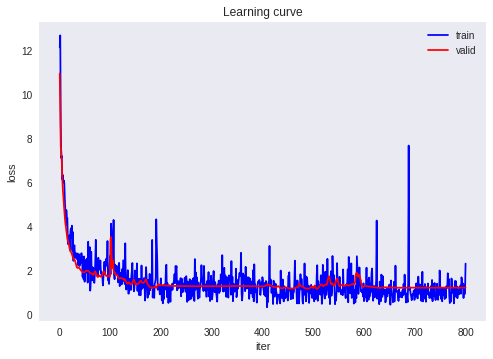

In [52]:
# Plot learning curve
plt.figure()
steps = np.arange(1, num_steps+1, 1)
plt.plot(steps, losses['train'], c='b', label='train')
plt.plot(steps, losses['valid'], c='r', label='valid')
plt.xlabel('iter')
plt.ylabel('loss')
plt.legend()
plt.title('Learning curve')
plt.grid()

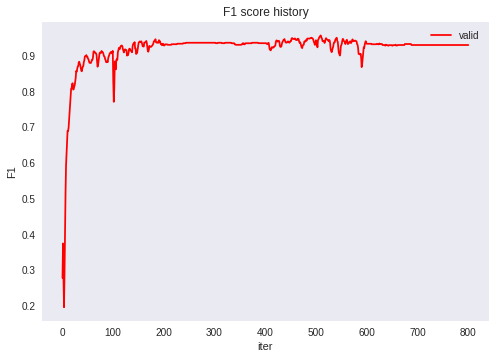

In [53]:
# Plot F1 scores
plt.figure()
steps = np.arange(1, num_steps+1, 1)
# plt.plot(steps, losses['train'], c='b', label='train')
plt.plot(steps, f1_scores['valid'], c='r', label='valid')
plt.xlabel('iter')
plt.ylabel('F1')
plt.legend()
plt.title('F1 score history')
plt.grid()

In [58]:
elmo_vars_dict = {v.name: v for v in elmo_vars}
saver_elmo = tf.train.Saver(elmo_vars_dict)
save_path = saver_elmo.save(sess, "/tmp/elmo.ckpt")
print("Model saved in path: %s" % save_path)
saver_all = tf.train.Saver()
save_path = saver_all.save(sess, "/tmp/model.ckpt")
print("Whole model saved in path: %s" % save_path)

Model saved in path: /tmp/elmo.ckpt
Whole model saved in path: /tmp/model.ckpt


In [57]:
print('Best F1 score on validation: {:.2f}'.format(best_valid_f1*100))
if TRAIN_ELMO:
    layer_coeff, scale = sess.run([elmo_coef['layer_coefficients'], elmo_coef['scaling']])
    elmo_params = {'layer_coefficients': layer_coeff, 'scaling': scale}
    elmo_layer_coeff = np.exp(elmo_params['layer_coefficients'])*elmo_params['scaling']
    print('Learned ELMo layer combination weights:')
    print(elmo_layer_coeff)
    print('Normalized:')
    print(np.exp(elmo_layer_coeff)/np.sum(np.exp(elmo_layer_coeff)))

Best F1 score on validation: 95.62
Learned ELMo layer combination weights:
[0.83144087 1.2586459  0.51261336]
Normalized:
[0.3067515  0.47023988 0.22300863]


In [56]:
elmo_vars

[<tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0' shape=(4096, 512) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0' shape=(4096, 512) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/proje